
Recall Performance Evaluation:
L2 (Concept) Recall: Cosine Similarity = 0.006, MSE = 0.9276
L1 (Feature) Recall: Cosine Similarity = 0.105, MSE = 0.6219

Visualizing original patterns...


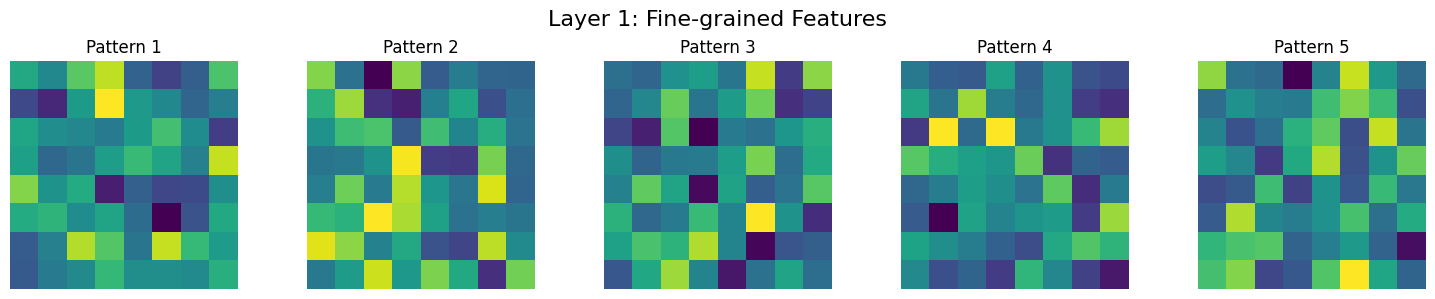

Visualizing concept associations...


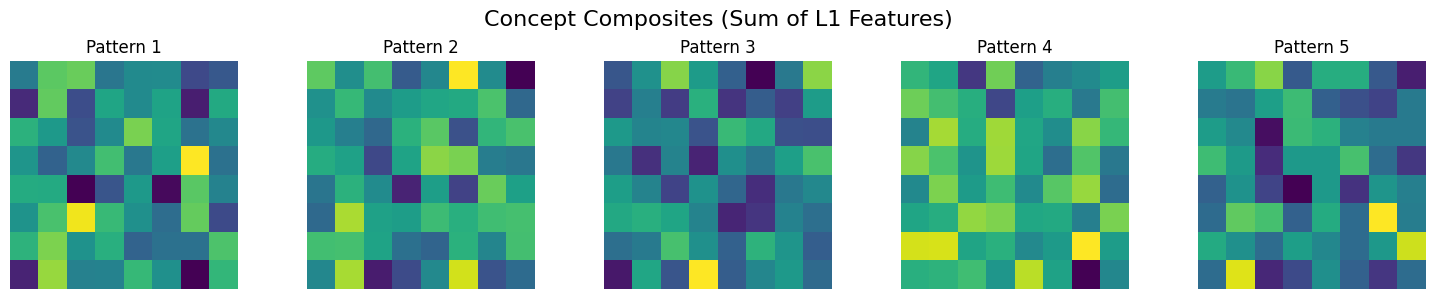

Visualizing recall results...


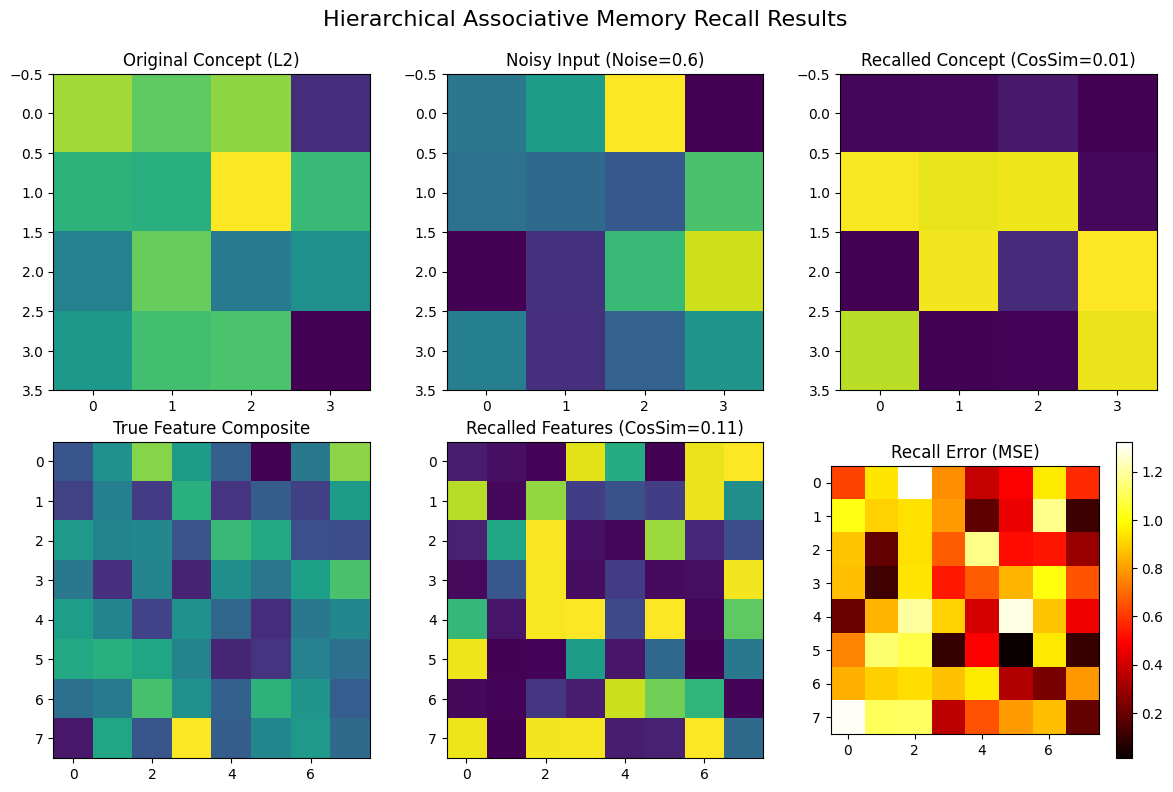

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

np.random.seed(42)

class HierarchicalAssociativeMemory:
    """
    A simplified implementation of Hierarchical Associative Memory (HAM)
    with two layers (L1: fine-grained features, L2: coarse-grained concepts)
    """
    
    def __init__(self, l1_dim=64, l2_dim=16):
        """
        Initialize HAM parameters
        
        Args:
            l1_dim: Dimension of Layer 1 (fine-grained features)
            l2_dim: Dimension of Layer 2 (coarse-grained concepts)
        """
        self.l1_dim = l1_dim
        self.l2_dim = l2_dim
        
        # Memory matrices
        self.W_l1 = None  # Layer 1 auto-associative memory
        self.W_l2 = None  # Layer 2 auto-associative memory
        self.W_l1l2 = None  # L1-L2 hetero-associative memory
        
    def train(self, l1_patterns, l2_patterns, associations):
        """
        Train the HAM model
        
        Args:
            l1_patterns: Matrix of L1 patterns (n_patterns, l1_dim)
            l2_patterns: Matrix of L2 patterns (n_patterns, l2_dim)
            associations: List of tuples (l2_idx, [l1_idxs]) defining concept compositions
        """
        n_patterns = l1_patterns.shape[0]
        
        # Train Layer 1 (auto-associative memory)
        self.W_l1 = np.zeros((self.l1_dim, self.l1_dim))
        for p in l1_patterns:
            self.W_l1 += np.outer(p, p)
        np.fill_diagonal(self.W_l1, 0)  # Remove self-connections
        
        # Train Layer 2 (auto-associative memory)
        self.W_l2 = np.zeros((self.l2_dim, self.l2_dim))
        for p in l2_patterns:
            self.W_l2 += np.outer(p, p)
        np.fill_diagonal(self.W_l2, 0)
        
        # Train L1-L2 associations (hetero-associative memory)
        self.W_l1l2 = np.zeros((self.l1_dim, self.l2_dim))
        for l2_idx, l1_idxs in associations:
            # Create composite pattern as sum of associated L1 patterns
            composite = np.sum(l1_patterns[l1_idxs], axis=0)
            self.W_l1l2 += np.outer(composite, l2_patterns[l2_idx])
    
    def recall(self, cue, max_iters=5, alpha=0.2, verbose=False):
        """
        Recall full pattern from partial input
        
        Args:
            cue: Input pattern (either L1 or L2 dimension)
            max_iters: Maximum recall iterations
            alpha: Update strength (0 < alpha < 1)
            verbose: Print debug info
            
        Returns:
            Reconstructed L1 pattern, reconstructed L2 pattern
        """
        # Determine input type based on dimension
        if len(cue) == self.l1_dim:
            current_l1 = cue.copy()
            current_l2 = np.zeros(self.l2_dim)
        elif len(cue) == self.l2_dim:
            current_l1 = np.zeros(self.l1_dim)
            current_l2 = cue.copy()
        else:
            raise ValueError("Cue dimension doesn't match network layers")
        
        for i in range(max_iters):
            # Update L1 (from current L1 and L2 associations)
            l1_update = self.W_l1 @ current_l1 + self.W_l1l2 @ current_l2
            l1_update = np.tanh(l1_update)  # Non-linear activation
            current_l1 = (1 - alpha) * current_l1 + alpha * l1_update
            
            # Update L2 (from current L2 and L1 associations)
            l2_update = self.W_l2 @ current_l2 + self.W_l1l2.T @ current_l1
            l2_update = np.tanh(l2_update)
            current_l2 = (1 - alpha) * current_l2 + alpha * l2_update
            
            if verbose:
                print(f"Iter {i+1}: L1 norm={np.linalg.norm(current_l1):.3f}, "
                      f"L2 norm={np.linalg.norm(current_l2):.3f}")
        
        return current_l1, current_l2

def generate_patterns(n_patterns, dim, ortho_strength=0.9):
    """
    Generate semi-orthogonal random patterns
    
    Args:
        n_patterns: Number of patterns to generate
        dim: Dimension of each pattern
        ortho_strength: Orthogonality strength (0-1)
        
    Returns:
        Matrix of patterns (n_patterns, dim)
    """
    patterns = np.random.randn(n_patterns, dim)
    
    # Apply Gram-Schmidt orthogonalization
    for i in range(n_patterns):
        for j in range(i):
            patterns[i] -= np.dot(patterns[i], patterns[j]) * patterns[j]
        patterns[i] /= np.linalg.norm(patterns[i])
    
    # Mix with random patterns for realism
    patterns = ortho_strength * patterns + (1 - ortho_strength) * np.random.randn(n_patterns, dim)
    return normalize(patterns)

def add_noise(pattern, noise_level=0.5):
    """Add random noise to a pattern"""
    noise = noise_level * np.random.randn(*pattern.shape)
    return np.clip(pattern + noise, -1, 1)

def visualize_patterns(patterns, title):
    """Visualize patterns as a grid of subplots"""
    n = len(patterns)
    fig, axes = plt.subplots(1, n, figsize=(3*n, 3))
    for i, (ax, pattern) in enumerate(zip(axes, patterns)):
        ax.imshow(pattern.reshape(int(np.sqrt(len(pattern))), 
                 int(np.sqrt(len(pattern)))), 
                 cmap='viridis', interpolation='nearest')
        ax.set_title(f'Pattern {i+1}')
        ax.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def evaluate_recall(original, recalled):
    """Evaluate recall performance with cosine similarity"""
    cosim = cosine_similarity(original.reshape(1, -1), recalled.reshape(1, -1))[0][0]
    mse = np.mean((original - recalled) ** 2)
    return cosim, mse

# Configuration
L1_DIM = 64  # Layer 1 dimension (8x8 patterns)
L2_DIM = 16  # Layer 2 dimension
N_L1_PATTERNS = 20
N_L2_PATTERNS = 5
NOISE_LEVEL = 0.6  # Input corruption level

# Generate patterns
l1_patterns = generate_patterns(N_L1_PATTERNS, L1_DIM, ortho_strength=0.8)
l2_patterns = generate_patterns(N_L2_PATTERNS, L2_DIM, ortho_strength=0.9)

# Create associations (each L2 concept = 3-5 L1 features)
associations = []
for l2_idx in range(N_L2_PATTERNS):
    n_features = np.random.randint(3, 6)
    l1_idxs = np.random.choice(N_L1_PATTERNS, n_features, replace=False)
    associations.append((l2_idx, l1_idxs))

# Initialize and train HAM
ham = HierarchicalAssociativeMemory(L1_DIM, L2_DIM)
ham.train(l1_patterns, l2_patterns, associations)

# Test recall with L2 cue
test_idx = 2  # Test with this L2 concept
noisy_l2 = add_noise(l2_patterns[test_idx], NOISE_LEVEL)
recalled_l1, recalled_l2 = ham.recall(noisy_l2, max_iters=10, alpha=0.3)

# Get true composite pattern
true_l1_idxs = [idx for _, idx in associations if _ == test_idx][0]
true_composite = np.sum(l1_patterns[true_l1_idxs], axis=0)

# Evaluate performance
cosim_l2, mse_l2 = evaluate_recall(l2_patterns[test_idx], recalled_l2)
cosim_l1, mse_l1 = evaluate_recall(true_composite, recalled_l1)

print("\n" + "="*50)
print("Recall Performance Evaluation:")
print(f"L2 (Concept) Recall: Cosine Similarity = {cosim_l2:.3f}, MSE = {mse_l2:.4f}")
print(f"L1 (Feature) Recall: Cosine Similarity = {cosim_l1:.3f}, MSE = {mse_l1:.4f}")
print("="*50 + "\n")

# Visualization
print("Visualizing original patterns...")
visualize_patterns(l1_patterns[:5], "Layer 1: Fine-grained Features")

print("Visualizing concept associations...")
composites = [np.sum(l1_patterns[idxs], axis=0) for _, idxs in associations]
visualize_patterns(composites, "Concept Composites (Sum of L1 Features)")

print("Visualizing recall results...")
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Original L2 concept
axes[0, 0].imshow(l2_patterns[test_idx].reshape(4, 4), cmap='viridis')
axes[0, 0].set_title('Original Concept (L2)')

# Noisy input
axes[0, 1].imshow(noisy_l2.reshape(4, 4), cmap='viridis')
axes[0, 1].set_title(f'Noisy Input (Noise={NOISE_LEVEL})')

# Recalled concept
axes[0, 2].imshow(recalled_l2.reshape(4, 4), cmap='viridis')
axes[0, 2].set_title(f'Recalled Concept (CosSim={cosim_l2:.2f})')

# True composite
axes[1, 0].imshow(true_composite.reshape(8, 8), cmap='viridis')
axes[1, 0].set_title('True Feature Composite')

# Recalled features
axes[1, 1].imshow(recalled_l1.reshape(8, 8), cmap='viridis')
axes[1, 1].set_title(f'Recalled Features (CosSim={cosim_l1:.2f})')

# Recall error
error = np.abs(true_composite - recalled_l1).reshape(8, 8)
axes[1, 2].imshow(error, cmap='hot', interpolation='nearest')
axes[1, 2].set_title('Recall Error (MSE)')
plt.colorbar(axes[1, 2].imshow(error, cmap='hot'), ax=axes[1, 2])

plt.tight_layout()
plt.suptitle("Hierarchical Associative Memory Recall Results", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import normalize

class HierarchicalHopfield:
    def __init__(self, input_dim, layer_dims=[32, 16, 8], beta=1.0):
        """
        :param input_dim: Dimension of input patterns
        :param layer_dims: List of dimensions for each layer (must be decreasing)
        :param beta: Inverse temperature parameter
        """
        self.input_dim = input_dim
        self.layer_dims = layer_dims
        self.beta = beta
        self.memories = []  # Stores patterns at each layer (features × samples)
        self.projections = []  # Projection matrices between layers
        
        # Validate layer dimensions
        assert all(l1 > l2 for l1, l2 in zip(layer_dims, layer_dims[1:])), \
            "Layer dimensions must be strictly decreasing"
        
    def store(self, patterns):
        """Store patterns with proper dimension handling"""
        # Clear previous storage
        self.memories = []
        self.projections = []
        
        # Convert to numpy array and validate shape
        patterns = np.array(patterns)
        assert patterns.shape[1] == self.input_dim, \
            f"Input dimension {patterns.shape[1]} != network input_dim {self.input_dim}"
        
        # Create projection matrices
        prev_dim = self.input_dim
        for next_dim in self.layer_dims:
            self.projections.append(np.random.randn(prev_dim, next_dim))
            prev_dim = next_dim
            
        # Project patterns through each layer
        current_data = patterns
        for proj in self.projections:
            projected = current_data @ proj  # (n_samples, next_dim)
            self.memories.append(projected.T)  # Store as (features × samples)
            current_data = normalize(projected, axis=1)
    
    def retrieve(self, query, max_iter=5):
        """Retrieve pattern with dimension validation"""
        # Ensure proper input shape (1 × input_dim)
        query = np.array(query)
        if query.ndim == 1:
            query = query.reshape(1, -1)
            
        assert query.shape[1] == self.input_dim, \
            f"Query dimension {query.shape[1]} != network input_dim {self.input_dim}"
            
        current = query
        energy_history = []
        
        for _ in range(max_iter):
            layer_outputs = []
            current = query
            for proj, mem in zip(self.projections, self.memories):
                # Project to current layer space
                print("current", current.shape)
                print(proj.shape, mem.shape)
                projected = current @ proj  # (1 × layer_dim)
                
                
                # Compute similarity with stored patterns
                similarity = self.beta * (projected @ mem)  # (1 × n_samples)
                
                # Compute attention weights
                weights = np.exp(similarity - np.max(similarity))
                weights = weights / np.sum(weights)
                
                # Retrieve weighted combination
                current = weights @ mem.T  # (1 × layer_dim)
                layer_outputs.append(current)
                
                # Record energy
                energy = -np.log(np.sum(np.exp(similarity))) + 0.5 * np.sum(current**2)
                energy_history.append(energy)
            
            # Top-down refinement with dimension checking
            for l in reversed(range(len(self.layer_dims)-1)):
                # Get current and upper layer outputs
                lower_output = layer_outputs[l]  # (1 × layer_dims[l])
                upper_output = layer_outputs[l+1]  # (1 × layer_dims[l+1])
                
                print("lower output" ,lower_output.shape)
                print("uper output", upper_output.shape)
                print("projections", self.projections[l+1].T.shape)
                # Project upper layer down to current layer space
                projected_down = upper_output @ self.projections[l+1].T  # (1 × layer_dims[l])
                
                # Refine current layer
                current = lower_output + 0.1 * projected_down
                print("top down current", current.shape)
                layer_outputs[l] = current  # Update for next iteration
                
        return current.squeeze(), energy_history

current (1, 64)
(64, 32) (32, 100)
current (1, 32)
(32, 16) (16, 100)
current (1, 16)
(16, 8) (8, 100)
lower output (1, 16)
uper output (1, 8)
projections (8, 16)
top down current (1, 16)
lower output (1, 32)
uper output (1, 16)
projections (16, 32)
top down current (1, 32)
current (1, 64)
(64, 32) (32, 100)
current (1, 32)
(32, 16) (16, 100)
current (1, 16)
(16, 8) (8, 100)
lower output (1, 16)
uper output (1, 8)
projections (8, 16)
top down current (1, 16)
lower output (1, 32)
uper output (1, 16)
projections (16, 32)
top down current (1, 32)
current (1, 64)
(64, 32) (32, 100)
current (1, 32)
(32, 16) (16, 100)
current (1, 16)
(16, 8) (8, 100)
lower output (1, 16)
uper output (1, 8)
projections (8, 16)
top down current (1, 16)
lower output (1, 32)
uper output (1, 16)
projections (16, 32)
top down current (1, 32)
current (1, 64)
(64, 32) (32, 100)
current (1, 32)
(32, 16) (16, 100)
current (1, 16)
(16, 8) (8, 100)
lower output (1, 16)
uper output (1, 8)
projections (8, 16)
top down cur

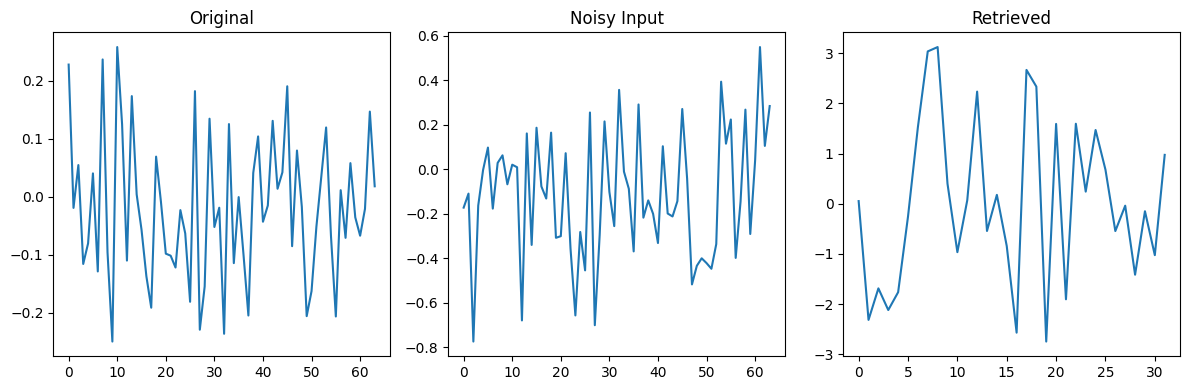

In [45]:
# Generate sample data
def generate_patterns(n_samples=100, dim=64):
    patterns = np.random.randn(n_samples, dim)
    return normalize(patterns, axis=1)

# Initialize and store patterns
patterns = generate_patterns(dim=64)
ham = HierarchicalHopfield(input_dim=64, layer_dims=[32, 16, 8])
ham.store(patterns)

# Test retrieval
query = patterns[0] + 0.3*np.random.randn(64)  # Add noise
retrieved, energies = ham.retrieve(query)

# Visualization
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title("Original")
plt.plot(patterns[0])

plt.subplot(132)
plt.title("Noisy Input")
plt.plot(query)

plt.subplot(133)
plt.title("Retrieved")
plt.plot(retrieved)

plt.tight_layout()
plt.show()

In [8]:
def generate_hierarchical_data(n_samples=300, input_dim=64):
    """Generate consistent hierarchical data"""
    # Base patterns (n_samples × input_dim)
    X, y = make_blobs(n_samples=n_samples, centers=3, n_features=input_dim, random_state=42)
    
    # Create compatible hierarchical structure
    patterns = [normalize(X, axis=1)]  # Only store normalized base patterns
    return patterns, y

# Usage:
patterns, labels = generate_hierarchical_data(input_dim=64)
ham = HierarchicalHopfield(dim=64, layers=[32, 16, 8])
ham.store(patterns[0])  # Pass only the base patterns

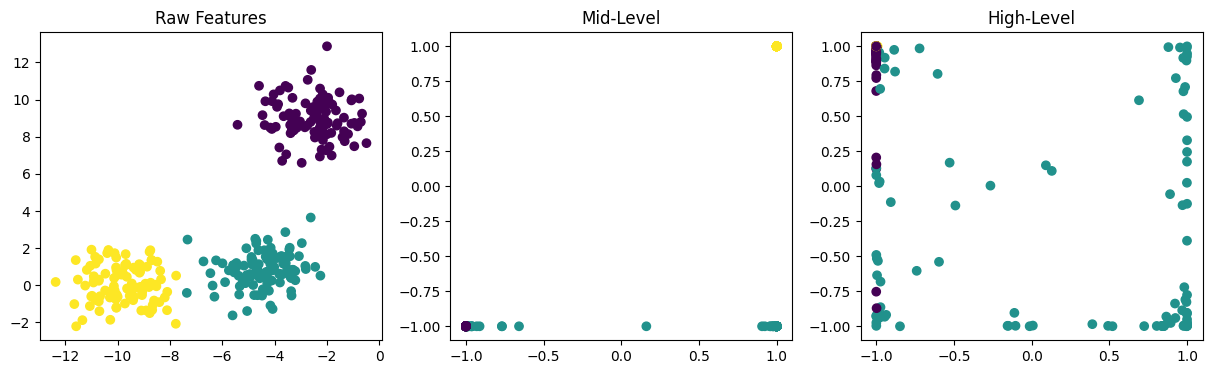

In [46]:
# Generate hierarchical feature data
def generate_hierarchical_data(n_samples=300):
    # Low-level features (raw data)
    X, y = make_blobs(n_samples=n_samples, centers=3, n_features=64, random_state=42)
    
    # Mid-level features (combined features)
    mid_proj = np.random.randn(64, 32)
    X_mid = np.tanh(X @ mid_proj)
    
    # High-level features (abstract concepts)
    high_proj = np.random.randn(32, 16)
    X_high = np.tanh(X_mid @ high_proj)
    
    return [X, X_mid, X_high], y

# Visualize data
patterns, labels = generate_hierarchical_data()
plt.figure(figsize=(15, 4))
for i, (data, title) in enumerate(zip(patterns, ['Raw Features', 'Mid-Level', 'High-Level'])):
    plt.subplot(1, 3, i+1)
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
    plt.title(title)
plt.show()

In [53]:
# Initialize 3-layer HAM
ham = ham = HierarchicalHopfield(input_dim=64, layer_dims=[32, 16, 8])

# Store patterns (training)
print(patterns[0].shape)
ham.store(patterns[0])

# Test noisy input recovery
def test_retrieval(ham, patterns, noise_level=0.3):
    original = patterns[0][0]
    noisy = original + noise_level * np.random.randn(*original.shape)
    noisy = normalize(noisy.reshape(1, -1))

    print(noisy.shape)
    
    retrieved, energies = ham.retrieve(noisy)
    
    similarities = [
        np.dot(original, patterns[0][0]),
        np.dot(retrieved[:32], patterns[1][0]),
       # np.dot(retrieved[48:], patterns[2][0])
    ]
    
    print(similarities)
    return noisy, retrieved, energies, similarities

noisy, retrieved, energies, similarities = test_retrieval(ham, patterns)

(300, 64)
(1, 64)
current (1, 64)
(64, 32) (32, 300)
current (1, 32)
(32, 16) (16, 300)
current (1, 16)
(16, 8) (8, 300)
lower output (1, 16)
uper output (1, 8)
projections (8, 16)
top down current (1, 16)
lower output (1, 32)
uper output (1, 16)
projections (16, 32)
top down current (1, 32)
current (1, 64)
(64, 32) (32, 300)
current (1, 32)
(32, 16) (16, 300)
current (1, 16)
(16, 8) (8, 300)
lower output (1, 16)
uper output (1, 8)
projections (8, 16)
top down current (1, 16)
lower output (1, 32)
uper output (1, 16)
projections (16, 32)
top down current (1, 32)
current (1, 64)
(64, 32) (32, 300)
current (1, 32)
(32, 16) (16, 300)
current (1, 16)
(16, 8) (8, 300)
lower output (1, 16)
uper output (1, 8)
projections (8, 16)
top down current (1, 16)
lower output (1, 32)
uper output (1, 16)
projections (16, 32)
top down current (1, 32)
current (1, 64)
(64, 32) (32, 300)
current (1, 32)
(32, 16) (16, 300)
current (1, 16)
(16, 8) (8, 300)
lower output (1, 16)
uper output (1, 8)
projections (8

/var/folders/3k/b0x9bxf15sggh4b5b10gx8dc0000gn/T/ipykernel_10141/2065210923.py:82: RuntimeWarning: overflow encountered in exp
  energy = -np.log(np.sum(np.exp(similarity))) + 0.5 * np.sum(current**2)


current (1, 64)
(64, 32) (32, 300)
current (1, 32)
(32, 16) (16, 300)
current (1, 16)
(16, 8) (8, 300)
lower output (1, 16)
uper output (1, 8)
projections (8, 16)
top down current (1, 16)
lower output (1, 32)
uper output (1, 16)
projections (16, 32)
top down current (1, 32)
current (1, 64)
(64, 32) (32, 300)
current (1, 32)
(32, 16) (16, 300)
current (1, 16)
(16, 8) (8, 300)
lower output (1, 16)
uper output (1, 8)
projections (8, 16)
top down current (1, 16)
lower output (1, 32)
uper output (1, 16)
projections (16, 32)
top down current (1, 32)
current (1, 64)
(64, 32) (32, 300)
current (1, 32)
(32, 16) (16, 300)
current (1, 16)
(16, 8) (8, 300)
lower output (1, 16)
uper output (1, 8)
projections (8, 16)
top down current (1, 16)
lower output (1, 32)
uper output (1, 16)
projections (16, 32)
top down current (1, 32)
current (1, 64)
(64, 32) (32, 300)
current (1, 32)
(32, 16) (16, 300)
current (1, 16)
(16, 8) (8, 300)
lower output (1, 16)
uper output (1, 8)
projections (8, 16)
top down cur

/var/folders/3k/b0x9bxf15sggh4b5b10gx8dc0000gn/T/ipykernel_10141/2065210923.py:82: RuntimeWarning: overflow encountered in exp
  energy = -np.log(np.sum(np.exp(similarity))) + 0.5 * np.sum(current**2)


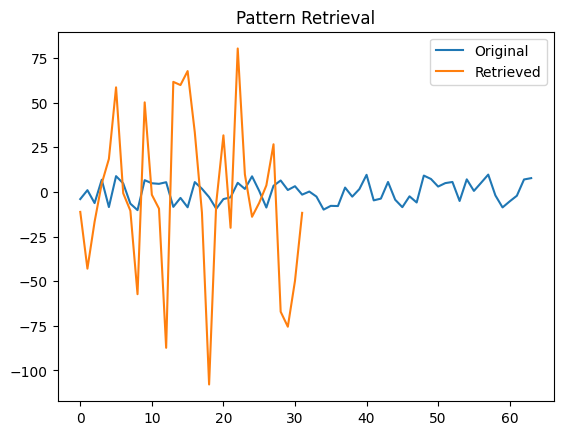

In [54]:
# Test retrieval
query = patterns[0][0] + 0.3*np.random.randn(64)  # Correct input dimension
retrieved, energies = ham.retrieve(query)

plt.plot(patterns[0][0], label='Original')
plt.plot(retrieved, label='Retrieved')
plt.legend()
plt.title("Pattern Retrieval")
plt.show()

In [ ]:
def plot_results(original, noisy, retrieved, energies):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(original, 'b-', label='Original')
    plt.plot(noisy, 'r--', label='Noisy Input')
    plt.legend()
    plt.title("Input Comparison")
    
    plt.subplot(2, 2, 2)
    plt.plot(original, 'b-', label='Original')
    plt.plot(retrieved, 'g-.', label='Retrieved')
    plt.legend()
    plt.title("Retrieval Result")
    
    plt.subplot(2, 2, 3)
    plt.plot(energies)
    plt.xlabel("Iteration")
    plt.ylabel("Energy")
    plt.title("Energy Dynamics")
    
    plt.subplot(2, 2, 4)
    plt.bar(['Low-Level', 'Mid-Level', 'High-Level'], similarities)
    plt.ylim(0, 1)
    plt.title("Layer-wise Similarity")
    
    plt.tight_layout()
    plt.show()

plot_results(patterns[0][0], noisy, retrieved, energies)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

class HierarchicalHopfield:
    def __init__(self, input_dim, layer_dims=[32, 16, 8], beta=1.0):
        """
        Hierarchical Hopfield Network implementation with dimension validation
        
        :param input_dim: Dimension of input patterns
        :param layer_dims: List of dimensions for each layer (must be decreasing)
        :param beta: Inverse temperature parameter (controls softmax sharpness)
        """
        self.input_dim = input_dim
        self.layer_dims = layer_dims
        self.beta = beta
        self.memories = []  # Stores patterns at each layer (features × samples)
        self.projections = []  # Projection matrices between layers
        
        # Validate layer dimensions
        if not all(l1 > l2 for l1, l2 in zip(layer_dims, layer_dims[1:])):
            raise ValueError("Layer dimensions must be strictly decreasing")
        
    def store(self, patterns):
        """Store patterns with proper dimension handling"""
        # Convert to numpy array and validate shape
        patterns = np.array(patterns)
        if patterns.shape[1] != self.input_dim:
            raise ValueError(f"Input dimension {patterns.shape[1]} != network input_dim {self.input_dim}")
        
        # Clear previous storage
        self.memories = []
        self.projections = []
        
        # Create projection matrices with proper dimensions
        prev_dim = self.input_dim
        for next_dim in self.layer_dims:
            # Initialize with random orthogonal projection
            proj = np.random.randn(prev_dim, next_dim)
            q, _ = np.linalg.qr(proj)  # Orthogonalize for better conditioning
            self.projections.append(q)
            prev_dim = next_dim
            
        # Project patterns through each layer
        current_data = patterns
        for proj in self.projections:
            # Project data to next layer: (n_samples, prev_dim) × (prev_dim, next_dim)
            projected = current_data @ proj  # Result: (n_samples, next_dim)
            
            # Store transposed: (features × samples)
            self.memories.append(projected.T)  
            
            # Normalize for next layer processing
            current_data = normalize(projected, axis=1)
    
    def retrieve(self, query, max_iter=5, verbose=False):
        """Retrieve pattern with dimension validation and top-down refinement"""
        # Ensure proper input shape (1 × input_dim)
        query = np.array(query)
        if query.ndim == 1:
            query = query.reshape(1, -1)
            
        if query.shape[1] != self.input_dim:
            raise ValueError(f"Query dimension {query.shape[1]} != network input_dim {self.input_dim}")
            
        current = query
        energy_history = []
        layer_outputs = []  # Store outputs at each layer during retrieval
        
        for _ in range(max_iter):
            iter_outputs = []  # Outputs for current iteration
            for l_idx, (proj, mem) in enumerate(zip(self.projections, self.memories)):
                # Project to current layer space: (1 × prev_dim) × (prev_dim, layer_dim)
                projected = current @ proj  # Result: (1 × layer_dim)
                
                # Compute similarity with stored patterns
                similarity = self.beta * (projected @ mem)  # (1 × n_samples)
                
                # Compute attention weights (softmax)
                weights = np.exp(similarity - np.max(similarity))
                weights = weights / np.sum(weights)
                
                # Retrieve weighted combination: (1 × n_samples) × (n_samples × layer_dim)
                current = weights @ mem.T  # Result: (1 × layer_dim)
                iter_outputs.append(current)
                
                # Record energy (negative log-likelihood + regularization)
                energy = -np.log(np.sum(np.exp(similarity))) + 0.5 * np.sum(current**2)
                energy_history.append(energy)
            
            # Store outputs for this iteration
            layer_outputs.append(iter_outputs)
            
            # Top-down refinement
            if len(self.layer_dims) > 1:
                # Start from top layer and refine downward
                refined = iter_outputs[-1]  # Top layer output
                
                # Refine each lower layer using the layer above it
                for l_idx in reversed(range(len(self.layer_dims)-1)):
                    # Project upper layer down to current layer space
                    # (1 × layer_dim_upper) × (layer_dim_upper × layer_dim_lower)
                    projected_down = refined @ self.projections[l_idx].T  # (1 × layer_dim_lower)
                    
                    # Refine current layer: combine bottom-up and top-down signals
                    current_layer = iter_outputs[l_idx] + 0.5 * projected_down
                    
                    # Update for next higher layer processing
                    refined = current_layer
        
        # Return final output and energy history
        return current.squeeze(), energy_history

# Data generation and visualization functions
def generate_patterns(n_samples=100, dim=64, cluster_centers=5, cluster_std=0.5):
    """Generate clustered patterns for more realistic memory structure"""
    # Generate cluster centers
    centers = np.random.randn(cluster_centers, dim)
    centers = normalize(centers, axis=1)
    
    # Generate samples around centers
    patterns = []
    for _ in range(n_samples):
        center_idx = np.random.randint(cluster_centers)
        pattern = centers[center_idx] + cluster_std * np.random.randn(dim)
        patterns.append(pattern)
    
    return normalize(patterns, axis=1)

def visualize_retrieval(original, noisy, retrieved, energies=None):
    """Visualize the retrieval process results"""
    plt.figure(figsize=(15, 5))
    
    # Pattern visualization
    plt.subplot(131)
    plt.title("Original Pattern")
    plt.imshow(original.reshape(8, 8), cmap='viridis')
    plt.colorbar()
    
    plt.subplot(132)
    plt.title("Noisy Input")
    plt.imshow(noisy.reshape(8, 8), cmap='viridis')
    plt.colorbar()
    
    plt.subplot(133)
    plt.title("Retrieved Pattern")
    plt.imshow(retrieved.reshape(8, 8), cmap='viridis')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()
    
    # Energy dynamics visualization
    if energies:
        plt.figure(figsize=(10, 4))
        plt.plot(energies, 'o-', linewidth=2)
        plt.title("Energy Dynamics During Retrieval")
        plt.xlabel("Processing Step (Layer × Iteration)")
        plt.ylabel("Energy")
        plt.grid(alpha=0.3)
        plt.show()

def evaluate_performance(original, retrieved):
    """Calculate performance metrics"""
    cosim = cosine_similarity(original.reshape(1, -1), retrieved.reshape(1, -1))[0][0]
    mse = np.mean((original - retrieved) ** 2)
    return cosim, mse

# Main workflow
if __name__ == "__main__":
    # Configuration
    INPUT_DIM = 64  # 8x8 patterns
    LAYER_DIMS = [48, 32, 16]  # Must be decreasing dimensions
    N_PATTERNS = 100
    NOISE_LEVEL = 0.8
    
    # Generate clustered patterns
    patterns = generate_patterns(n_samples=N_PATTERNS, dim=INPUT_DIM, 
                                 cluster_centers=8, cluster_std=0.4)
    
    # Initialize and store patterns
    hhn = HierarchicalHopfield(input_dim=INPUT_DIM, layer_dims=LAYER_DIMS, beta=2.0)
    hhn.store(patterns)
    
    # Select a test pattern
    test_idx = 42
    original = patterns[test_idx]
    
    # Create noisy query
    noisy = original + NOISE_LEVEL * np.random.randn(INPUT_DIM)
    noisy = normalize(noisy.reshape(1, -1))[0]  # Renormalize
    
    # Retrieve pattern
    retrieved, energies = hhn.retrieve(noisy, max_iter=5)
    
    # Evaluate performance
    cosim, mse = evaluate_performance(original, retrieved)
    print(f"\nRetrieval Performance:")
    print(f"Cosine Similarity: {cosim:.4f}")
    print(f"MSE: {mse:.6f}")
    print(f"Energy Reduction: {energies[0]:.2f} → {energies[-1]:.2f} "
          f"({100*(energies[0]-energies[-1])/energies[0]:.1f}% reduction)")
    
    # Visualization
    visualize_retrieval(original, noisy, retrieved, energies)
    
    # Dimensionality analysis
    print("\nDimensionality Analysis:")
    print(f"Input dimension: {INPUT_DIM}")
    for i, dim in enumerate(LAYER_DIMS):
        print(f"Layer {i+1} dimension: {dim} "
              f"({100*dim/INPUT_DIM:.1f}% of input)")

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

class HierarchicalHopfield:
    def __init__(self, input_dim, layer_dims=[32, 16, 8], beta=1.0):
        self.input_dim = input_dim
        self.layer_dims = layer_dims
        self.beta = beta
        self.memories = []
        self.projections = []
        
        if not all(l1 > l2 for l1, l2 in zip(layer_dims, layer_dims[1:])):
            raise ValueError("Layer dimensions must be strictly decreasing")
        
    def store(self, patterns):
        patterns = np.array(patterns)
        if patterns.shape[1] != self.input_dim:
            raise ValueError(f"Input dimension {patterns.shape[1]} != network input_dim {self.input_dim}")
        
        self.memories = []
        self.projections = []
        
        prev_dim = self.input_dim
        for next_dim in self.layer_dims:
            proj = np.random.randn(prev_dim, next_dim)
            q, _ = np.linalg.qr(proj)
            self.projections.append(q)
            prev_dim = next_dim
            
        current_data = patterns
        for proj in self.projections:
            projected = current_data @ proj
            self.memories.append(projected.T)
            current_data = normalize(projected, axis=1)
    
    def retrieve(self, query, max_iter=5, verbose=False):
        query = np.array(query)
        if query.ndim == 1:
            query = query.reshape(1, -1)
            
        if query.shape[1] != self.input_dim:
            raise ValueError(f"Query dimension {query.shape[1]} != network input_dim {self.input_dim}")
            
        current = query
        energy_history = []
        layer_outputs = []

        for _ in range(max_iter):
            iter_outputs = []
            for proj, mem in zip(self.projections, self.memories):
                projected = current @ proj
                similarity = self.beta * (projected @ mem)
                
                weights = np.exp(similarity - np.max(similarity))
                weights = weights / np.sum(weights)
                
                current = weights @ mem.T
                iter_outputs.append(current)
                
                energy = -np.log(np.sum(np.exp(similarity))) + 0.5 * np.sum(current**2)
                energy_history.append(energy)
            
            layer_outputs.append(iter_outputs)
            
            # Top-down refinement with corrected projection index
            if len(self.layer_dims) > 1:
                refined = iter_outputs[-1]
                
                # Traverse from top layer down to first hidden layer
                for l_idx in reversed(range(len(self.layer_dims)-1)):
                    # Use projection matrix at index l_idx+1 (connection between l_idx and l_idx+1)
                    projected_down = refined @ self.projections[l_idx+1].T
                    
                    # Combine with bottom-up signal
                    current_layer = iter_outputs[l_idx] + 0.5 * projected_down
                    
                    # Update for next lower layer
                    refined = current_layer
        
        return current.squeeze(), energy_history

# Data generation and visualization functions remain the same

# Main workflow with corrected implementation
if __name__ == "__main__":
    # Configuration
    INPUT_DIM = 64
    LAYER_DIMS = [48, 32, 16]
    N_PATTERNS = 100
    NOISE_LEVEL = 0.8
    
    # Generate clustered patterns
    patterns = generate_patterns(n_samples=N_PATTERNS, dim=INPUT_DIM, 
                                 cluster_centers=8, cluster_std=0.4)
    
    # Initialize and store patterns
    hhn = HierarchicalHopfield(input_dim=INPUT_DIM, layer_dims=LAYER_DIMS, beta=2.0)
    hhn.store(patterns)
    
    # Select a test pattern
    test_idx = 42
    original = patterns[test_idx]
    
    # Create noisy query
    noisy = original + NOISE_LEVEL * np.random.randn(INPUT_DIM)
    noisy = normalize(noisy.reshape(1, -1))[0]
    
    # Retrieve pattern
    retrieved, energies = hhn.retrieve(noisy, max_iter=5)
    
    # Evaluate performance
    cosim, mse = evaluate_performance(original, retrieved)
    print(f"\nRetrieval Performance:")
    print(f"Cosine Similarity: {cosim:.4f}")
    print(f"MSE: {mse:.6f}")
    print(f"Energy Reduction: {energies[0]:.2f} → {energies[-1]:.2f} "
          f"({100*(energies[0]-energies[-1])/energies[0]:.1f}% reduction)")
    
    # Visualization
    visualize_retrieval(original, noisy, retrieved, energies)
    
    # Dimensionality analysis
    print("\nDimensionality Analysis:")
    print(f"Input dimension: {INPUT_DIM}")
    for i, dim in enumerate(LAYER_DIMS):
        print(f"Layer {i+1} dimension: {dim} "
              f"({100*dim/INPUT_DIM:.1f}% of input)")

TypeError: generate_patterns() got an unexpected keyword argument 'cluster_centers'